<a href="https://colab.research.google.com/github/mrckie/cardio-health-classifier/blob/main/First_Laboratory_Exam_Set_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Libraries**

In [104]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## **1. Dataset Analysis and Preparation**


*   Numeric features: BMI, PhysicalHealth, MentalHealth, SleepTime, AgeCategory, GenHealth.

*  Binary features: Smoking, AlcoholDrinking, Stroke, DiffWalking, Sex, Diabetic, PhysicalActivity, Asthma, KidneyDisease, SkinCancer.

* One-hot encoded features: Race categories.

* Target: HeartDisease (0 for No, 1 for Yes).

**Load Dataset**

In [105]:
data = pd.read_csv('heart_2020_uncleaned.csv')
data.head(10)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,no,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,no,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,no,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No
5,Yes,28.87,yes,No,No,6.0,0.0,Yes,Female,75-79,Black,No,No,Fair,12.0,No,No,No
6,No,21.63,no,No,No,15.0,0.0,No,Female,70-74,White,No,Yes,Fair,4.0,Yes,No,Yes
7,No,31.64,yes,No,No,5.0,0.0,Yes,Female,80 or older,White,Yes,No,Good,9.0,Yes,No,No
8,No,26.45,no,No,No,0.0,0.0,No,Female,80 or older,White,"No, borderline diabetes",No,Fair,5.0,No,Yes,No
9,No,40.69,no,No,No,0.0,0.0,Yes,Male,65-69,White,No,Yes,Good,10.0,No,No,No


**Before handling missing values**

In [106]:
data.isnull().sum()

,0
HeartDisease,0
BMI,150
Smoking,0
AlcoholDrinking,0
Stroke,0
PhysicalHealth,120
MentalHealth,0
DiffWalking,0
Sex,0
AgeCategory,0


**Impute the missing values with the median to avoid outliers skewing results.**

**After handling the missing values:**

In [107]:
data['BMI'] = data['BMI'].fillna(data['BMI'].median())
data['PhysicalHealth'] = data['PhysicalHealth'].fillna(data['PhysicalHealth'].median())
data['SleepTime'] = data['SleepTime'].fillna(data['SleepTime'].median())
data.isnull().sum()

,0
HeartDisease,0
BMI,0
Smoking,0
AlcoholDrinking,0
Stroke,0
PhysicalHealth,0
MentalHealth,0
DiffWalking,0
Sex,0
AgeCategory,0


**Handle Inconsistent Data**

Diabetic Column: The column includes "No, borderline diabetes" and "Yes (during pregnancy)". Simplify to:

Yes: Includes "Yes" and "Yes (during pregnancy)".

No: Includes "No" and "No, borderline diabetes".





In [108]:
data['Diabetic'] = data['Diabetic'].replace({'No, borderline diabetes': 'No', 'Yes (during pregnancy)': 'Yes'})

**Conversion of AgeCategory and GenHealth Category**

In [109]:
# Convert categorical age ranges to numeric midpoints (e.g., "55-59" to 57).
age_map = {'18-24': 21, '25-29': 27, '30-34': 32, '35-39': 37, '40-44': 42,
           '45-49': 47, '50-54': 52, '55-59': 57, '60-64': 62, '65-69': 67,
           '70-74': 72, '75-79': 77, '80 or older': 82}
data['AgeCategory'] = data['AgeCategory'].map(age_map)


# Convert to ordinal scale (e.g., Poor=1, Fair=2, Good=3, Very good=4, Excellent=5)
genhealth_map = {'Poor': 1, 'Fair': 2, 'Good': 3, 'Very good': 4, 'Excellent': 5}
data['GenHealth'] = data['GenHealth'].map(genhealth_map)

**Encode Categorical Variables**

Converting the following binary categorical variables (e.g., Smoking, AlcoholDrinking) to 0/1.

In [110]:
data['Smoking'] = data['Smoking'].map({'yes': 1, 'no': 0})
data['AlcoholDrinking'] = data['AlcoholDrinking'].map({'Yes': 1, 'No': 0})
data['DiffWalking'] = data['DiffWalking'].map({'Yes': 1, 'No': 0})
data['Stroke'] = data['Stroke'].map({'Yes': 1, 'No': 0})
data['Diabetic'] = data['Diabetic'].map({'Yes': 1, 'No': 0})
data['PhysicalActivity'] = data['PhysicalActivity'].map({'Yes': 1, 'No': 0})
data['SkinCancer'] = data['SkinCancer'].map({'Yes': 1, 'No': 0})
data['KidneyDisease'] = data['KidneyDisease'].map({'Yes': 1, 'No': 0})
data['Asthma'] = data['Asthma'].map({'Yes': 1, 'No': 0})
data['Sex'] = data['Sex'].map({'Male': 1, 'Female': 0})
data.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,1,0,0,3.0,30.0,0,0,57,White,1,1,4,5.0,1,0,1
1,No,20.34,0,0,1,0.0,0.0,0,0,82,White,0,1,4,7.0,0,0,0
2,No,26.58,1,0,0,20.0,30.0,0,1,67,White,1,1,2,8.0,1,0,0
3,No,24.21,0,0,0,0.0,0.0,0,0,77,White,0,0,3,6.0,0,0,1
4,No,23.71,0,0,0,28.0,0.0,1,0,42,White,0,1,4,8.0,0,0,0


**Using one-hot encoding for multi-category variables (e.g., Race).**

In [111]:
data = pd.get_dummies(data, columns=['Race'], prefix='Race')
data.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,...,SleepTime,Asthma,KidneyDisease,SkinCancer,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White
0,No,16.60,1,0,0,3.0,30.0,0,0,57,...,5.0,1,0,1,False,False,False,False,False,True
1,No,20.34,0,0,1,0.0,0.0,0,0,82,...,7.0,0,0,0,False,False,False,False,False,True
2,No,26.58,1,0,0,20.0,30.0,0,1,67,...,8.0,1,0,0,False,False,False,False,False,True
3,No,24.21,0,0,0,0.0,0.0,0,0,77,...,6.0,0,0,1,False,False,False,False,False,True
4,No,23.71,0,0,0,28.0,0.0,1,0,42,...,8.0,0,0,0,False,False,False,False,False,True


**Checking the class distribution of Heart Disease**

In [112]:
display(data['HeartDisease'].value_counts())

,count
HeartDisease,
No,292422
Yes,27373


Since the Dataset is Imbalanced it has more 'No' than 'Yes' we apply oversampling (e.g., SMOTE) or undersampling.



---



**Balance the Dataset**

In [113]:
X = data.drop('HeartDisease', axis=1)
y = data['HeartDisease'].map({"Yes": 1, "No": 0})
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
display(y_resampled.value_counts())

,count
HeartDisease,
0,292422
1,292422


## **2. Binary Classification Strategy**


*   Task: Binary classification to predict HeartDisease (Yes/No).
*   Output: Probability score (confidence) to indicate risk level.
*   Evaluation Metric: Use accuracy, precision, recall, and F1-score. Prioritize recall to minimize false negatives (missing at-risk patients).






**Model Training**

Split Data: 80/20 train-test split.

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

**Train Random Forest**

In [115]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

**Evaluate Model**

In [116]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuary: {accuracy:.4f}")
print('Classification Report')
print(report)

Accuary: 0.9123
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.91      0.91     58485
           1       0.91      0.92      0.91     58484

    accuracy                           0.91    116969
   macro avg       0.91      0.91      0.91    116969
weighted avg       0.91      0.91      0.91    116969



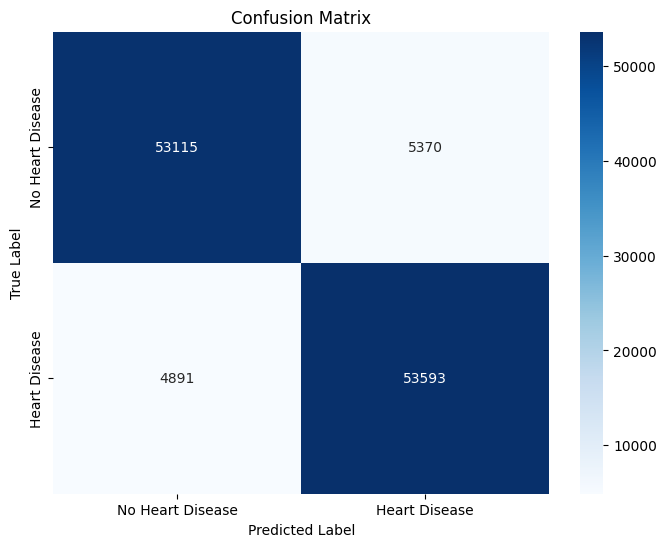

In [117]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**Save Model**

In [118]:
joblib.dump(model, 'cardio_health_classifier.pkl')

['cardio_health_classifier.pkl']